# Stellar Mass Functions (SMFs)

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
plt.rc('text', usetex=True)

In [4]:
#data
Illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
TNG_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'
BAHAMAS_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/BAHAMAS/bahamas_z0.38_aperture_masses.fits'
Massive_Black_II_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/MassiveBlack-II/mblack2_z0.30_aperture_masses.fits'
Horizon_AGN_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Horizon-AGN/horizon_z0.37_aperture_masses.fits'

HSC_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_wide_massive_fastlane_imgsub_master_use_camira.fits'

### Song's SMF functions

In [3]:
def compute_smf_song(sm_array, volume, nb, sm_min, sm_max,
                smf_only=False, return_bins=False):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of x axis

    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err : ndarray
        Poisson error
    """

    smf, bin_edges = np.histogram(sm_array, bins=nb,
                                  range=[sm_min, sm_max])

    # bin width in dex
    # !! Only works for constant bin size now
    mass_bin_width = (bin_edges[1] - bin_edges[0])

    # Normalize
    smf = (smf / volume / mass_bin_width)

    # Poison error
    if not smf_only:
        err = np.sqrt(smf)
        # Also normalize the err
        err = (err / volume / mass_bin_width)
        # X-axis
        x = bin_edges[:-1] + (mass_bin_width / 2.0)

    if not smf_only:
        if return_bins:
            return x, smf, err, bin_edges
        else:
            return x, smf, err
    else:
        # For bootstrap run
        return smf


def bootstrap_resample(X, n_boots=1000):
    """
    Bootstrap resample an array_like.
    Borrowed from: http://nbviewer.jupyter.org/gist/aflaxman/6871948

    Parameters
    ----------
    X : array_like
      data to resample
    n_boots : int, optional
      Number of bootstrap resamples
      default = 1000

    Results
    -------
    returns X_resamples
    """
    return np.vstack(
        X[np.floor(np.random.rand(len(X))*len(X)).astype(int)]
        for ii in np.arange(n_boots)).T


def bootstrap_smf_song(sm_array, volume, nb, sm_min, sm_max,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3

    nb : number of bins

    sm_min : min of x axis

    sm_max : max of y axis

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    smf : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err_poison : ndarray
        Poisson error

    smf_boots : ndarray
        Bootstrapped SMFs
    
    bins : edges of bins 
    """

    x, smf, err_poison, bins = compute_smf(sm_array, volume, nb,
                                           sm_min, sm_max,
                                           return_bins=True)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(
            map(lambda mass, err: np.random.normal(mass, err, n_boots),
                sm_array, sm_err))
    else:
        sm_boots = bootstrap_resample(sm_array, n_boots=n_boots)

    smf_boots = np.vstack(
        compute_smf(sm_boots[:, ii], volume, nb, sm_min, sm_max, smf_only=True)
        for ii in range(n_boots)
    )
    
    return x, smf, err_poison, smf_boots, bins

## Modified functions

In [5]:
def compute_smf(log_masses, volume, n_bins, min_mass, max_mass):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) #Unnormalized histogram and bin edges
    dM    = edg[1] - edg[0]                 #Bin size
    m_centers   = edg[0:-1] + dM/2.           #Mass axis
    Phi   = Phi / float(volume) / dM             #Normalize to volume and bin size
    log_phi= np.log10(Phi) 

    # Poisson error
    err = np.sqrt(Phi)
    # Also normalize the err
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err


def bootstrap_smf(log_masses, volume, n_bins, min_mass, max_mass,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
        
    log_boot_err : ndarray
        log of Poisson error


    """

    m_centers, phi, err_poisson = compute_smf(log_masses, volume, n_bins, min_mass, max_mass)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(map(lambda mass, err: np.random.normal(mass, err, n_boots),
                log_masses, sm_err))
    else:
        mass_boot_samples = bootstrap_resample(log_masses, n_boots=n_boots)

    phi_boots = np.vstack(compute_smf(mass_boot_samples[:, ii], volume, n_bins, sm_min, sm_max)[1] 
                              for ii in range(n_boots))
    
    #bootstrap error
    err_bootstrap=np.nanstd(phi_boots, axis=0)
    log_err_bootstrap=np.nanstd(np.log10(phi_boots[phi_boots != 0.0]), axis=0)
    
    
    
    return m_centers, phi, err_poisson, err_bootstrap, log_err_bootstrap, phi_boots

## get masses


In [6]:
# Illustris
f = h5py.File(Illustris_file, 'r')
cat_sh_mstars = np.array(f['cat_sh_mstar'])
f.close()
m_stars_illustris=np.log10(cat_sh_mstars)
mean_illustris=round(np.mean(m_stars_illustris),2)
median_illustris=round(np.median(m_stars_illustris),2)
std_illustris=round(np.std(m_stars_illustris),2)

#TNG
f = h5py.File(TNG_file, 'r')
cat_sh_mstars = np.array(f['cat_sh_mstar'])
f.close()
m_stars_tng=np.log10(cat_sh_mstars)
mean_tng=round(np.mean(m_stars_tng),2)
median_tng=round(np.median(m_stars_tng),2)
std_tng=round(np.std(m_stars_tng),2)


In [33]:
print max(m_stars_illustris), min(m_stars_illustris), len(m_stars_illustris)
print max(m_stars_tng), min(m_stars_tng), len(m_stars_tng)

12.4148511258 11.2015086567 339
12.4499482946 11.2016944807 235


## other parameters


In [49]:
volume_illustris=106.5**3 #Mpc^3
n_bins= 7
sm_min=11.2
sm_max=12.4

## SMFs

In [50]:
m_illustris, smf_illustris, err_illustris = compute_smf(m_stars_illustris, volume_illustris,n_bins, sm_min, sm_max)
m_tng, smf_tng, err_tng = compute_smf(m_stars_tng, volume_illustris,n_bins, sm_min, sm_max)

## PLOTS


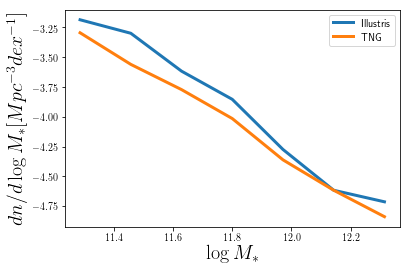

In [51]:
plt.plot(m_illustris,np.log10(smf_illustris), linewidth=3, label='Illustris')
plt.plot(m_tng,np.log10(smf_tng), linewidth=3, label='TNG')

plt.fill_between(m_illustris,np.log10(smf_illustris+10*err_illustris), np.log10(smf_illustris-10*err_illustris)) #Poisson error smaller than line
plt.fill_between(m_tng,np.log10(smf_tng+10*err_tng), np.log10(smf_tng-10*err_tng)) #Poisson error smaller than line

plt.xlabel(r'$\log{M_*}$', fontsize=20)
plt.ylabel(r'$dn / d\log{M_*}[Mpc^{-3} dex^{-1}]$', fontsize=20)
plt.legend()
plt.show()

# add other sims
(from Song's notebook `s16a_mblack2_smf_compare.ipynb`)

In [9]:
# h0 
HSMALL = 0.70
H0 = 70.0

# MassiveBlack-2
ZMBLACK2 = 0.30
SMBLACK2 = 100.0  # Mpc
# Bahamas simulation
ZBAHAMAS = 0.38
SBAHAMAS = 250.0  # Mpc
# Horizon
ZHORIZON = 0.37
SHORIZON = 100.0  # Mpc

# S16A 
S16A_AREA = 144.7  # deg^2

In [10]:
#MassiveBlack-II
mblack2 = Table.read(Massive_Black_II_file, format='fits')
volMBlack2 = (SMBLACK2 / HSMALL) ** 3.0  # Mpc**3
print("# Volume for MassiveBlack-II : %f Mpc^3" % volMBlack2)

# Volume for MassiveBlack-II : 2915451.895044 Mpc^3


In [11]:
#BAHAMAS
bahamas = Table.read(BAHAMAS_file, format='fits')
volBahamas = (SMBLACK2 / HSMALL) ** 3.0  # Mpc**3
print("# Volume for Bahamas : %f Mpc^3" % volBahamas)

# Volume for Bahamas : 2915451.895044 Mpc^3


In [18]:
#Horizon-AGN
horizon = Table.read(Horizon_AGN_file, format='fits')
volHorizon = (SHORIZON / HSMALL) ** 3.0  # Mpc**3
print("# Volume for Horizon : %f Mpc^3" % volHorizon)
horizon.add_column(Column(np.log10(horizon['col6']), name='logm_3d')) #col6 -> 3D mass

# Volume for Horizon : 2915451.895044 Mpc^3


## using full stellar mass for now

In [52]:
m_MB2, smf_MB2, err_MB2 = compute_smf(mblack2['logmstar'], volMBlack2, n_bins, sm_min, sm_max)

m_BAHAMAS, smf_BAHAMAS, err_BAHAMAS = compute_smf(bahamas['logM100_3D'], volBahamas, n_bins, sm_min, sm_max)

m_horizon, smf_horizon, err_horizon = compute_smf(horizon['logm_3d'], volHorizon, n_bins, sm_min, sm_max)

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10


## HSC (skip for now)

In [ ]:
#HSC
fastMaster = Table.read(HSC_file, format='fits')
# fastPhotoz = Table.read(os.path.join(envir['sbpsum'],'s16a_wide_massive_fastlane_pzbright_imgsub_master_use.fits'),
#     format='fits')


# Stellar mass function using cModel luminosity
mbin, s16aMAll1 = mass_function.getVolumeDensity(
    fastMaster, massCol='MSTAR', area=S16A_AREA, 
    errValue=0.04, returnAll=True, minVal=1.0E-9,
    verbose=True, zLow=np.nanmin(fastMaster['z_best']), 
    zUpp=np.nanmax(fastMaster['z_best']),
    rhoCorrection=1.05, nResample=10000)

s16aMLow1 = np.nanpercentile(s16aMAll1, 3.0, axis=0)
s16aMUpp1 = np.nanpercentile(s16aMAll1, 97.0, axis=0)
s16aMMed1 = np.nanmedian(s16aMAll1, axis=0)

## PLOTS

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10


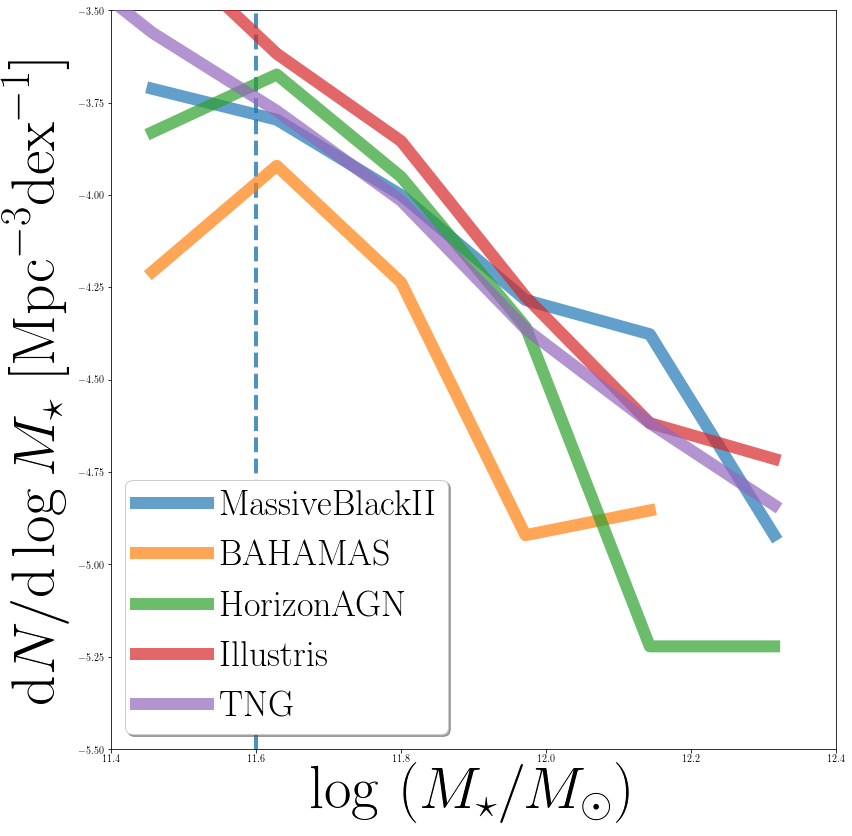

In [53]:
fig = plt.figure(figsize=(13, 12))
fig.subplots_adjust(left=0.22, right=0.995, 
                    bottom=0.14, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
# ax1 = plotting.songAxisSetup(
#     ax1, xlabel=50, ylabel=50, border=6.5,
#     xtickFormat='$\mathrm{%4.1f}$', 
#     ytickFormat='$\mathrm{%4.1f\ }$')


# S16A
# ax1.fill_between(mbin, s16aMLow5, s16aMUpp5, 
#                  facecolor=BLK(0.5), 
#                  edgecolor='none', alpha=0.3, 
#                  zorder=0, rasterized=True)

# ax1.plot(mbin, s16aMMed5, c=BLK(0.6), linestyle='--', linewidth=10.0,
#          label=r'$\mathrm{HSC}\ \mathrm{30\ kpc}$', 
#          zorder=2, rasterized=True, dashes=(20, 4))

# Massive Black II 
ax1.plot(m_MB2, np.log10(smf_MB2), linestyle='-', linewidth=12.0, zorder=5, alpha=0.7,label=r'$\mathrm{MassiveBlackII}$') 

# Bahamas
ax1.plot(m_BAHAMAS, np.log10(smf_BAHAMAS), linestyle='-', linewidth=12.0, zorder=5, alpha=0.7, label=r'$\mathrm{BAHAMAS}$')

# Horizon
ax1.plot(m_horizon, np.log10(smf_horizon), linestyle='-', linewidth=12.0, zorder=5, alpha=0.7, label=r'$\mathrm{HorizonAGN}$')

#Illustris
ax1.plot(m_illustris,np.log10(smf_illustris), linestyle='-', linewidth=12.0, zorder=5, alpha=0.7, label=r'$\mathrm{Illustris}$')

#TNG
ax1.plot(m_tng,np.log10(smf_tng), linestyle='-', linewidth=12.0, zorder=5, alpha=0.7, label=r'$\mathrm{TNG}$')

# Legend
ax1.legend(loc=(0.02, 0.02), shadow=True, fancybox=True, 
           numpoints=1, fontsize=36, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.34)

# X-Y limits
ax1.set_xlim(11.4, 12.4)
ax1.set_ylim(-5.5, -3.5)

# Label
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)

#ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)

ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

# fig.savefig(os.path.join(envir['fig'], 
#                          's16a_fastlane_smf_simulation_9.png'), 
#             dpi=100)

plt.show()

# Next steps:
* separate between M_30kpc and M_100kpc